In [6]:
#from google.colab import drive
#drive.mount('/content/gdrive')
#!cat '/content/gdrive/MyDrive/Colab Notebooks/INSY695 Enterprise ML A2/causalml'
#!pip install -r '/content/gdrive/MyDrive/Colab Notebooks/INSY695 Enterprise ML A2/causalml/requirements.txt'

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
#pip install causalml

In [8]:
import pandas as pd
import numpy as np
from causalml.inference.meta import LRSRegressor, XGBTRegressor
from causalml.inference.tree import UpliftTreeClassifier, UpliftRandomForestClassifier
from causalml.inference.meta import BaseXRegressor
from causalml.metrics import plot_gain
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
import matplotlib.pyplot as plt

In [ ]:
from pathlib import Path
DATA_PATH = Path() / "../data"
DATA_PATH.mkdir(parents=True,exist_ok=True)

def load_data(filename, data_path=DATA_PATH,encoding='ISO-8859-1'):
    csv_path = data_path / filename
    return pd.read_csv(csv_path,encoding=encoding)

def save_data(data, filename, data_path=DATA_PATH,encoding='ISO-8859-1'):
    csv_path = data_path / filename
    data.to_csv(csv_path, index=False,encoding='ISO-8859-1')

PLOT_PATH = Path() / "../plot"
PLOT_PATH.mkdir(parents=True,exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300, transparent=True):
    path = PLOT_PATH / f"{fig_id}.{fig_extension}"
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution, transparent=transparent)

In [9]:
import statsmodels.api as sm
from sklearn.metrics import roc_auc_score

In [13]:
#df_train = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/INSY695 Enterprise ML A2/data/train_df.csv")
df_train = load_data("train_df.csv")
df_train

,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,MntGoldProds,...,RFM_Group_At Risk,RFM_Group_Hibernating,RFM_Group_Loyalist,RFM_Group_Need Attention,RFM_Group_New Customers,RFM_Group_Potential Loyalist,RFM_Group_Promising,Age_Demographic_Baby Boomer,Age_Demographic_Gen X,Age_Demographic_Gen Y
0,-0.907878,1.042749,-0.939402,0.993008,-0.832494,-0.661714,-0.688503,-0.648271,-0.624425,-0.814261,...,-0.131533,1.889431,-0.540655,-0.124676,-0.127,-0.558143,-0.142278,-0.787296,1.071727,-0.423255
1,2.069402,-0.822778,0.907984,0.889557,2.090909,0.162166,1.165943,1.248667,1.773901,-0.547871,...,-0.131533,-0.529260,-0.540655,-0.124676,-0.127,1.791654,-0.142278,1.270171,-0.933073,-0.423255
2,-0.412309,1.042749,0.907984,1.199910,-0.894443,-0.636748,-0.725407,-0.648271,-0.624425,-0.776206,...,-0.131533,1.889431,-0.540655,-0.124676,-0.127,-0.558143,-0.142278,-0.787296,1.071727,-0.423255
3,-0.493002,1.042749,-0.939402,1.061976,-0.847243,-0.461985,-0.665438,-0.415627,-0.575974,-0.681066,...,-0.131533,1.889431,-0.540655,-0.124676,-0.127,-0.558143,-0.142278,-0.787296,-0.933073,2.362645
4,-0.102784,1.042749,-0.939402,-1.696718,-0.000607,-0.661714,-0.420946,-0.684062,-0.648651,-0.414676,...,-0.131533,-0.529260,1.849609,-0.124676,-0.127,-0.558143,-0.142278,-0.787296,1.071727,-0.423255
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1759,-0.854501,-0.822778,-0.939402,-0.110469,-0.791194,-0.611781,-0.688503,-0.540897,-0.648651,-0.738150,...,-0.131533,-0.529260,-0.540655,-0.124676,-0.127,-0.558143,-0.142278,-0.787296,-0.933073,2.362645
1760,0.974171,-0.822778,0.907984,0.717139,2.701549,0.037336,-0.111872,-0.684062,-0.309493,2.344366,...,-0.131533,-0.529260,-0.540655,-0.124676,-0.127,-0.558143,7.028513,-0.787296,1.071727,-0.423255
1761,0.282502,-0.822778,-0.939402,0.337819,1.259023,0.336928,0.086489,0.246511,-0.164140,-0.281481,...,-0.131533,-0.529260,-0.540655,-0.124676,-0.127,1.791654,-0.142278,1.270171,-0.933073,-0.423255
1762,-1.181238,1.042749,0.907984,-0.351855,-0.800044,-0.661714,-0.679277,-0.684062,-0.648651,-0.795233,...,-0.131533,-0.529260,-0.540655,-0.124676,-0.127,-0.558143,-0.142278,1.270171,-0.933073,-0.423255


In [15]:


# Define the features for each AcceptedCmp
features_dict = {
    'AcceptedCmp1': ['MntTotal', 'MntWines', 'Income', 'MntRegularProds', 'MntMeatProducts', 'Customer_Days', 'NumCatalogPurchases', 'MntFishProducts', 'Recency', 'MntSweetProducts'],
    'AcceptedCmp2': ['MntWines', 'MntMeatProducts', 'MntRegularProds', 'Income', 'MntTotal', 'Recency', 'Customer_Days', 'MntFruits', 'NumWebPurchases', 'Age'],
    'AcceptedCmp3': ['MntGoldProds', 'MntRegularProds', 'MntTotal', 'Income', 'Customer_Days', 'MntWines', 'MntMeatProducts', 'Age', 'NumStorePurchases', 'Recency'],
    'AcceptedCmp4': ['MntWines', 'MntMeatProducts', 'MntRegularProds', 'MntTotal', 'Income', 'Customer_Days', 'MntFishProducts', 'MntSweetProducts', 'AcceptedCmp2', 'Recency'],
    'AcceptedCmp5': ['Income', 'MntWines', 'MntTotal', 'MntRegularProds', 'MntMeatProducts', 'MntSweetProducts', 'MntFishProducts', 'MntFruits', 'Customer_Days', 'NumCatalogPurchases']
}

results = []

for campaign, features in features_dict.items():
    treatment = features[0]  # The first feature is considered as the treatment
    covariates = features[1:]  # The rest of the features are considered as covariates

    # Prepare the data
    X = df_train[covariates]
    treatment = df_train[treatment].apply(lambda x: 1 if x > 0 else 0)  # Convert treatment to binary
    y = df_train[campaign].apply(lambda x: 1 if x > 0 else 0)  # Convert campaign acceptance to binary

    # Splitting the dataset into training and testing sets
    X_train, X_test, treatment_train, treatment_test, y_train, y_test = train_test_split(X, treatment, y, test_size=0.3, random_state=42)

    # Initialize the UpliftTreeClassifier
    uplift_model_tree = UpliftTreeClassifier(control_name='0')

    # Fit the model
    uplift_model_tree.fit(X_train.values,
                           treatment=treatment_train.map(str),
                           y=y_train)

    # Predict the uplift
    uplift_pred_tree = uplift_model_tree.predict(X_test.values)

    # You can also use UpliftRandomForestClassifier in a similar way if needed
    # Initialize and fit the model, then predict the uplift

    # Collecting the results
    results.append((campaign, uplift_pred_tree))

# You'll need to further process 'results' to evaluate the model's performance or extract insights



In [16]:
results

[('AcceptedCmp1',
  array([[0.00417537, 0.16333333],
         [0.00417537, 0.16333333],
         [0.01104972, 0.11111111],
         ...,
         [0.00417537, 0.16333333],
         [0.00417537, 0.16333333],
         [0.00417537, 0.16333333]])),
 ('AcceptedCmp2',
  array([[0.        , 0.06214689],
         [0.        , 0.06214689],
         [0.        , 0.06214689],
         ...,
         [0.        , 0.03100775],
         [0.        , 0.06214689],
         [0.        , 0.06214689]])),
 ('AcceptedCmp3',
  array([[0.05797101, 0.05681818],
         [0.05797101, 0.05681818],
         [0.03353659, 0.12411348],
         ...,
         [0.03353659, 0.12411348],
         [0.21875   , 0.27272727],
         [0.03353659, 0.12411348]])),
 ('AcceptedCmp4',
  array([[0.03125   , 0.09124088],
         [0.03125   , 0.09124088],
         [0.0198556 , 0.44444444],
         ...,
         [0.01904762, 0.225     ],
         [0.0198556 , 0.44444444],
         [0.0198556 , 0.44444444]])),
 ('AcceptedCmp5',
  

In [18]:
# Define the campaigns and their respective features
campaign_features = [
    ('AcceptedCmp1', ['MntTotal', 'MntWines', 'Income', 'MntRegularProds', 'MntMeatProducts', 'Customer_Days', 'NumCatalogPurchases', 'MntFishProducts', 'Recency', 'MntSweetProducts']),
    ('AcceptedCmp2', ['MntWines', 'MntMeatProducts', 'MntRegularProds', 'Income', 'MntTotal', 'Recency', 'Customer_Days', 'MntFruits', 'NumWebPurchases', 'Age']),
    ('AcceptedCmp3', ['MntGoldProds', 'MntRegularProds', 'MntTotal', 'Income', 'Customer_Days', 'MntWines', 'MntMeatProducts', 'Age', 'NumStorePurchases', 'Recency']),
    ('AcceptedCmp4', ['MntWines', 'MntMeatProducts', 'MntRegularProds', 'MntTotal', 'Income', 'Customer_Days', 'MntFishProducts', 'MntSweetProducts', 'AcceptedCmp2', 'Recency']),
    ('AcceptedCmp5', ['Income', 'MntWines', 'MntTotal', 'MntRegularProds', 'MntMeatProducts', 'MntSweetProducts', 'MntFishProducts', 'MntFruits', 'Customer_Days', 'NumCatalogPurchases'])
]

# Initialize estimators
lr_model = LRSRegressor()
xgb_model = XGBTRegressor()

results = []

for campaign, features in campaign_features:
    print(f"Analyzing {campaign}...")
    # Define treatment and features
    treatment = df_train[features[0]].apply(lambda x: 1 if x > df_train[features[0]].median() else 0)
    X = df_train[features[1:]]  # covariates
    y = df_train[campaign]

    # Split the data
    X_train, X_test, treatment_train, treatment_test, y_train, y_test = train_test_split(X, treatment, y, test_size=0.2, random_state=42)

    # Fit the models
    lr_model.fit(X=X_train, treatment=treatment_train, y=y_train)
    xgb_model.fit(X=X_train, treatment=treatment_train, y=y_train)

    # Predict the ITEs
    lr_ite = lr_model.predict(X_test)
    xgb_ite = xgb_model.predict(X_test)

    # Store results
    results.append({
        'campaign': campaign,
        'LRSRegressor_ITE': lr_ite,
        'XGBTRegressor_ITE': xgb_ite
    })

# Print or analyze the results as needed
for result in results:
    print(result['campaign'])
    print("LRSRegressor ITE Estimates:", result['LRSRegressor_ITE'][:5])  # Displaying first 5 ITE estimates as an example
    print("XGBTRegressor ITE Estimates:", result['XGBTRegressor_ITE'][:5])

Analyzing AcceptedCmp1...
Analyzing AcceptedCmp2...
Analyzing AcceptedCmp3...
Analyzing AcceptedCmp4...
Analyzing AcceptedCmp5...
AcceptedCmp1
LRSRegressor ITE Estimates: [[-0.12424035]
 [-0.12424035]
 [-0.12424035]
 [-0.12424035]
 [-0.12424035]]
XGBTRegressor ITE Estimates: [[-0.00172844]
 [-0.0002729 ]
 [ 0.08650302]
 [-0.0027224 ]
 [ 0.01533909]]
AcceptedCmp2
LRSRegressor ITE Estimates: [[-0.04529776]
 [-0.04529776]
 [-0.04529776]
 [-0.04529776]
 [-0.04529776]]
XGBTRegressor ITE Estimates: [[ 0.997356  ]
 [ 0.00304455]
 [ 0.01617244]
 [-0.00352584]
 [ 0.00192563]]
AcceptedCmp3
LRSRegressor ITE Estimates: [[0.08931123]
 [0.08931123]
 [0.08931123]
 [0.08931123]
 [0.08931123]]
XGBTRegressor ITE Estimates: [[-0.00057794]
 [ 0.01193419]
 [-0.01006905]
 [-0.02913109]
 [-0.02919528]]
AcceptedCmp4
LRSRegressor ITE Estimates: [[-0.00396344]
 [-0.00396344]
 [-0.00396344]
 [-0.00396344]
 [-0.00396344]]
XGBTRegressor ITE Estimates: [[-0.0009802 ]
 [-0.02757635]
 [ 0.64990354]
 [ 0.01034196]
 [-

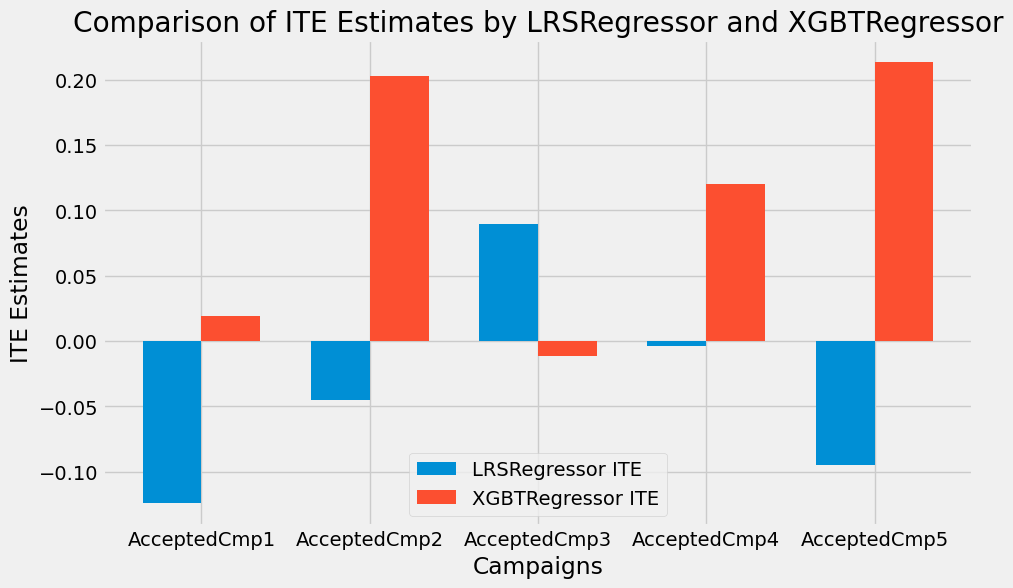

In [19]:
# Sample data from the provided output
campaigns = ['AcceptedCmp1', 'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5']
lrs_ite_means = [-0.12424035, -0.04529776, 0.08931123, -0.00396344, -0.09480083]
xgbt_ite_means = [np.mean([-0.00172844, -0.0002729, 0.08650302, -0.0027224, 0.01533909]),
                  np.mean([0.997356, 0.00304455, 0.01617244, -0.00352584, 0.00192563]),
                  np.mean([-0.00057794, 0.01193419, -0.01006905, -0.02913109, -0.02919528]),
                  np.mean([-0.0009802, -0.02757635, 0.64990354, 0.01034196, -0.03061549]),
                  np.mean([0.993369281, 0.0381313786, -0.000437054958, -0.00177220383, 0.0397669077])]

# Creating the plot
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(len(campaigns))

# Plotting both LRSRegressor and XGBTRegressor ITE estimates
bars1 = plt.bar(index, lrs_ite_means, bar_width, label='LRSRegressor ITE')
bars2 = plt.bar(index + bar_width, xgbt_ite_means, bar_width, label='XGBTRegressor ITE')

# Adding labels and title
plt.xlabel('Campaigns')
plt.ylabel('ITE Estimates')
plt.title('Comparison of ITE Estimates by LRSRegressor and XGBTRegressor')
plt.xticks(index + bar_width / 2, campaigns)
plt.legend()